# FLX_JP-BBY
partition FLUXNET-CH4 data from Bibai bog into diffusive and ebullitive fluxes

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P
from sklearn.linear_model import LinearRegression

In [2]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## Import data and process

In [3]:
df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

plot entire FCH4 series vs time

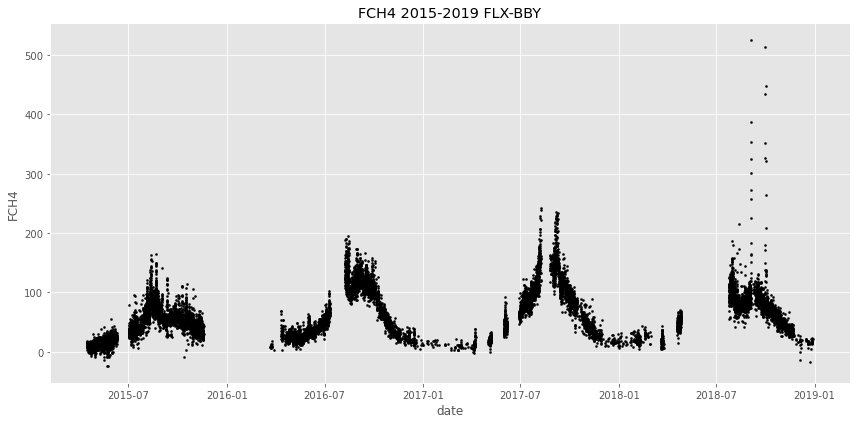

In [5]:
p.scatterdate(df.index, df['FCH4'], xlabel='date', ylabel='FCH4', title="FCH4 2015-2019 FLX-BBY")

ebullition ~2018-08?

In [6]:
dfw = df.loc['2018-07-01':'2019-01-01']

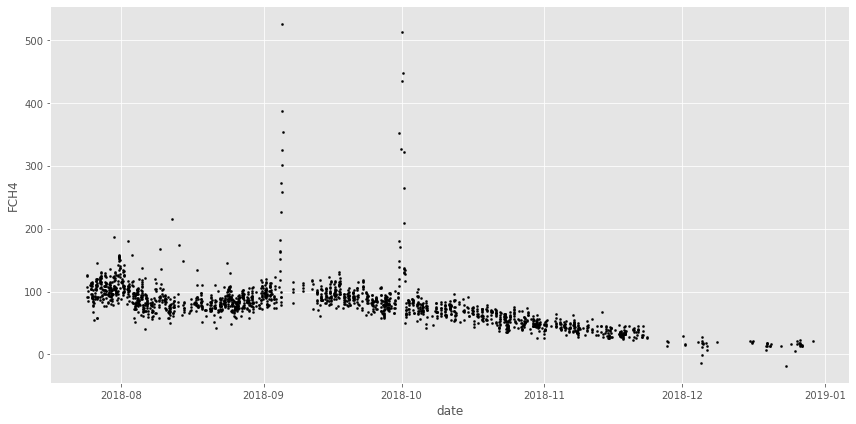

In [7]:
p.scatterdate(dfw.index, dfw['FCH4'], xlabel = 'date', ylabel = 'FCH4')

trim off Dec and sparse regions in Nov 

In [8]:
dfw = dfw.loc['2018-08-01':'2018-11-22']
dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
dfw.tail()

,TIMESTAMP_START,TIMESTAMP_END,NEE,H,LE,FCH4,USTAR,SW_IN,SW_OUT,LW_IN,...,G_F,WTD_F,WS_F,LE_F_ANNOPTLM,NEE_F_ANNOPTLM,FCH4_F_ANNOPTLM,FCH4_F_RANDUNC,FCH4_F_ANNOPTLM_UNC,FCH4_F_ANNOPTLM_QC,date
date,,,,,,,,,,,,,,,,,,,,,
2018-11-22 08:30:00,201811220830,201811220900,NaN,10.299,NaN,27.759,0.117947,162.733,30.072,250.470,...,-8.4635,-0.033667,1.173,8.881268,-0.002383,27.759,14.054628,NaN,1,2018-11-22 08:30:00
2018-11-22 09:00:00,201811220900,201811220930,0.24140,19.067,NaN,27.083,0.128069,220.863,30.408,264.760,...,-8.5348,-0.033667,1.492,12.958019,0.241400,27.083,13.862763,NaN,1,2018-11-22 09:00:00
2018-11-22 09:30:00,201811220930,201811221000,1.07490,51.908,44.564,44.661,0.154567,271.138,36.671,268.875,...,-8.5913,-0.033667,1.330,44.564000,1.074900,44.661,10.889463,NaN,1,2018-11-22 09:30:00
2018-11-22 10:00:00,201811221000,201811221030,0.37500,38.059,32.652,37.238,0.118917,221.318,23.119,287.204,...,-8.6442,-0.033333,1.470,32.652000,0.375000,37.238,10.391490,NaN,1,2018-11-22 10:00:00
2018-11-22 10:30:00,201811221030,201811221100,-0.44658,18.734,20.402,30.939,0.101577,159.709,12.566,293.984,...,-8.6673,-0.033333,1.075,20.402000,-0.446580,30.939,14.003261,NaN,1,2018-11-22 10:30:00


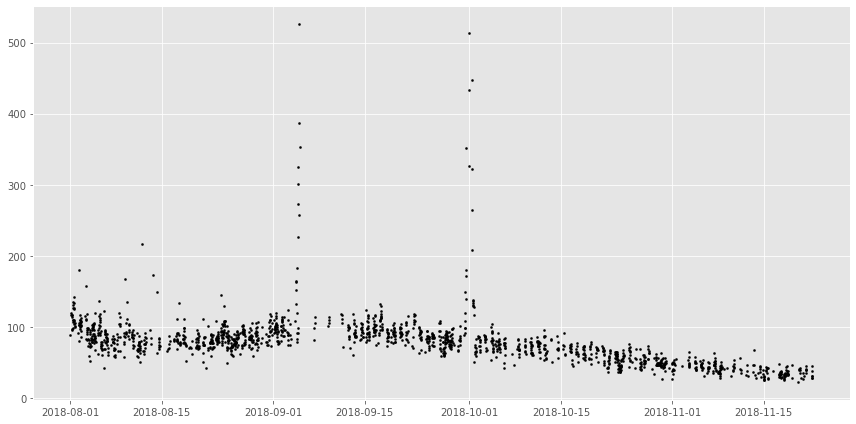

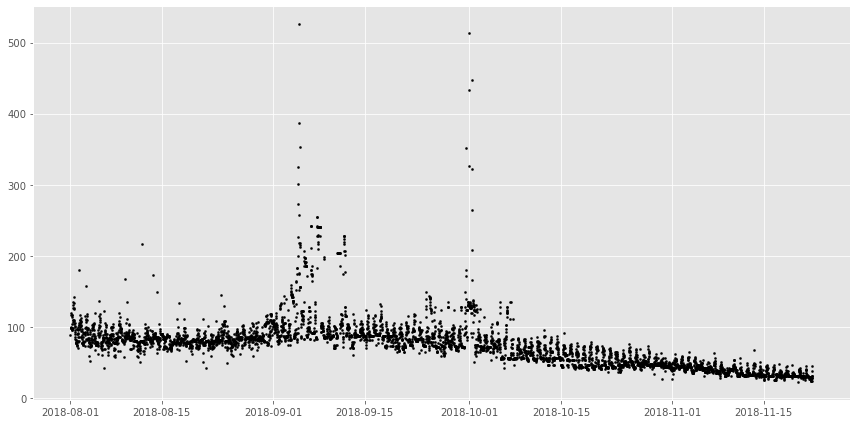

In [9]:
p.scatterdate(dfw.index, dfw['FCH4'])
p.scatterdate(dfw.index, dfw['FCH4_F'])

gap-filling adding some info after first big spike (~mid Sept), but I'll use it and see what happens

In [10]:
# normalize
nM, [xpM, ypM] = wave.norm(dfw.loc[:, 'FCH4_F'].to_numpy())
nLE, [xpLE, ypLE] = wave.norm(dfw.loc[:, 'LE_F'])
nT, [xpT, ypT] = wave.norm(dfw.loc[:, 'TA_F'])

In [11]:
# add normalized series to df
df.loc[dfw.index, 'FCH4_Fn'] = nM
df.loc[dfw.index, 'LE_Fn'] = nLE
df.loc[dfw.index, 'TA_Fn'] = nT

In [12]:
# compute wavelet coefficients using MODWT
[cM, cT, cLE] = wave.mra8(df.loc[dfw.index, ['FCH4_Fn', 'TA_Fn', 'LE_Fn']].to_numpy(), level=7, axis=0)

In [13]:
# sum wavelet scales and calculate scale windows
csumM, scalesM = wave.sum_scales(cM)
csumT, scalesT = wave.sum_scales(cT)
csumLE, scalesLE = wave.sum_scales(cLE)

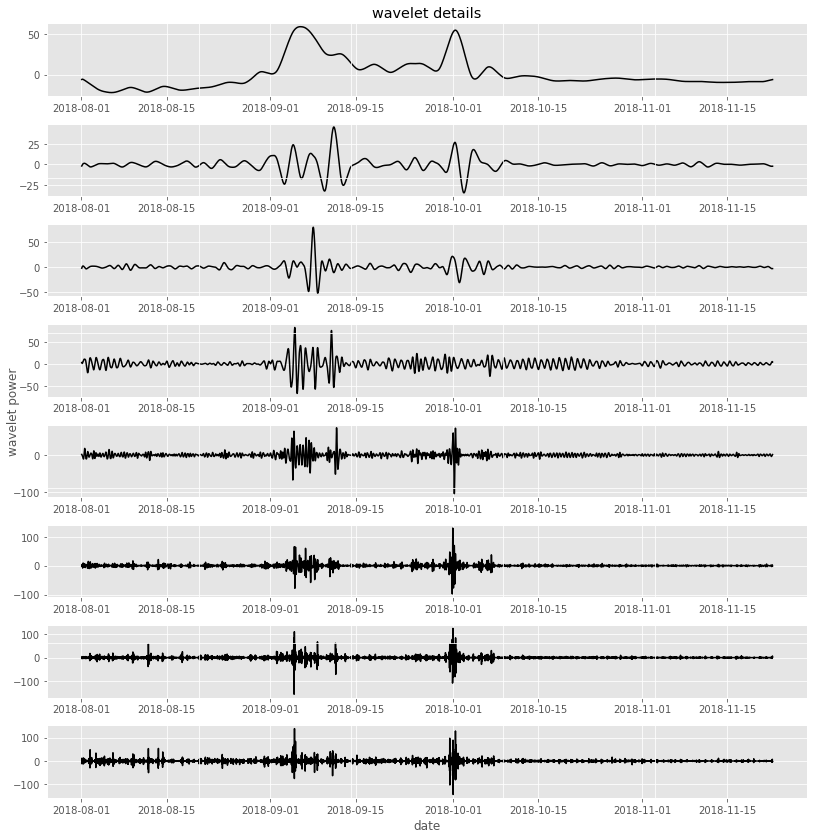

In [14]:
p.wavelet(dfw.index, cM)

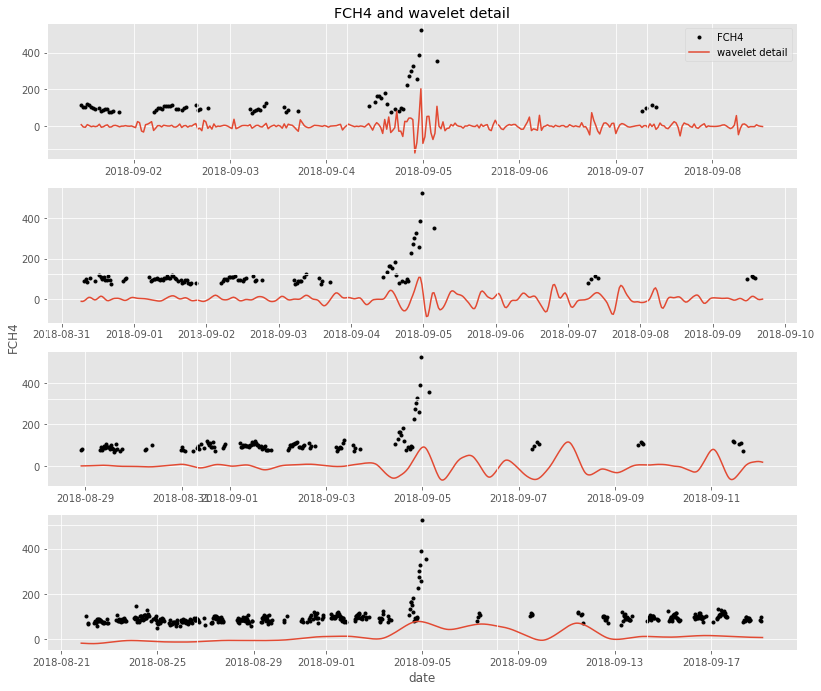

In [15]:
p.reconst(df.loc[dfw.index, 'FCH4'], csumM, scalesM, '2018-09-05', ypM, ylabel = 'FCH4')

In [16]:
zdate = pd.to_datetime('2018-09-05')

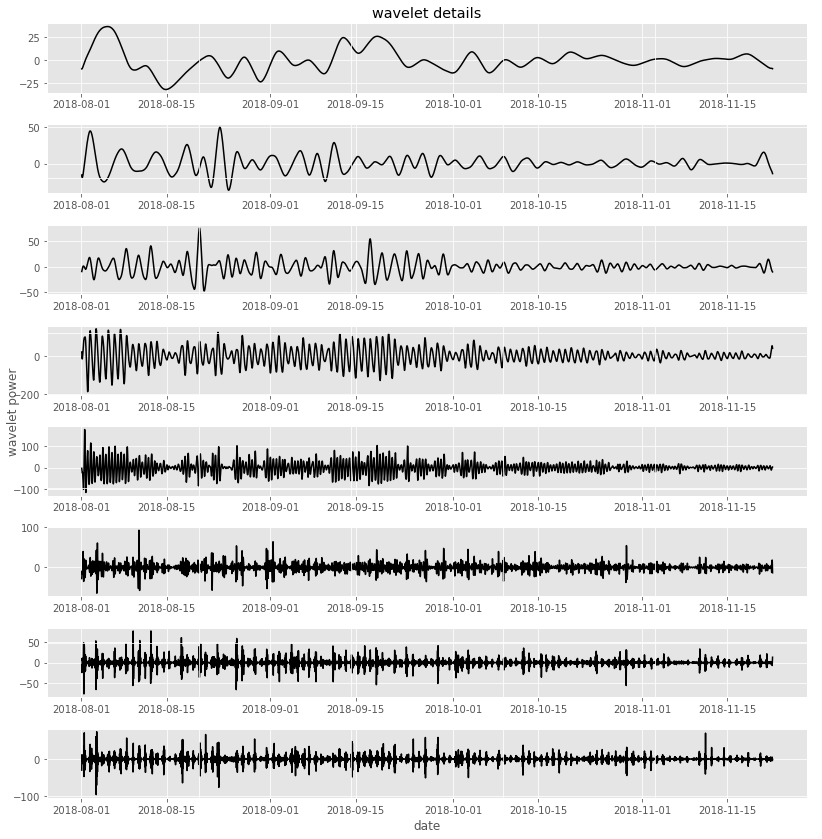

In [17]:
p.wavelet(dfw.index, cLE)

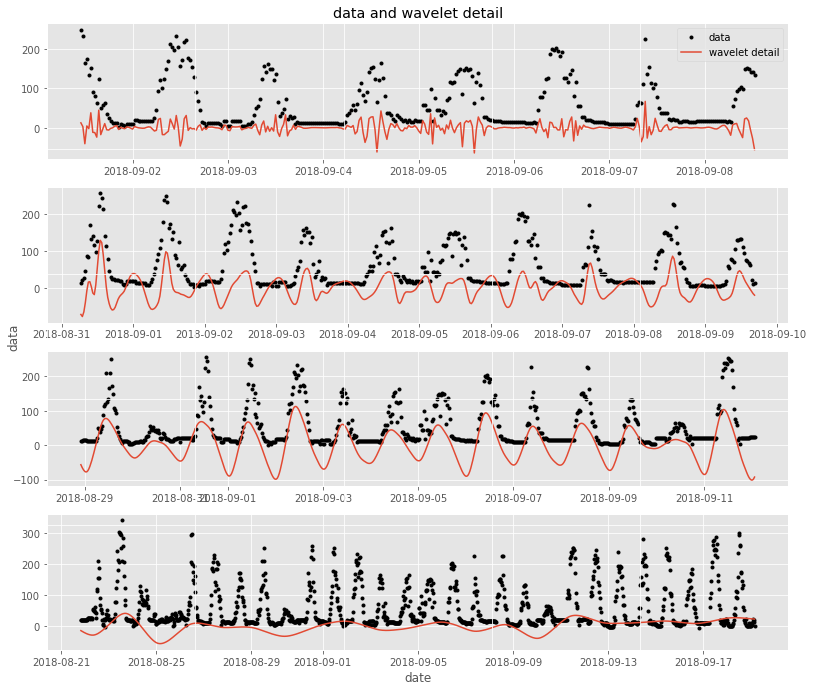

In [18]:
p.reconst(df.loc[dfw.index, 'LE_F'], csumLE, scalesLE, '2018-09-05', ypLE)

In [49]:
df.loc[dfw.index, ['FCH4_w{}'.format(j) for j in range(len(csumM))]] = np.array(csumM).T

df.loc[dfw.index, ['LE_w{}'.format(j) for j in range(len(csumLE))]] = np.array(csumLE).T

df.loc[dfw.index, ['TA_w{}'.format(j) for j in range(len(csumT))]] = np.array(csumT).T

In [55]:
df.loc[dfw.index, 'LE_w0':'LE_w3']

,LE_w0,LE_w1,LE_w2,LE_w3
date,,,,
2018-08-01 01:30:00,-24.986436,11.012337,-31.461346,-35.151512
2018-08-01 02:00:00,-26.204862,-0.375916,-33.528173,-17.231668
2018-08-01 02:30:00,-27.306110,-11.003460,-32.876686,-2.309906
2018-08-01 03:00:00,-28.039987,-18.383592,-31.967418,2.592483
2018-08-01 03:30:00,-28.154131,-20.042348,-32.804608,7.402920
...,...,...,...,...
2018-11-22 08:30:00,-20.097685,44.478529,11.196737,-0.210289
2018-11-22 09:00:00,-20.716722,43.206978,18.354813,-8.898730
2018-11-22 09:30:00,-21.387224,40.184467,14.751977,-1.549834


In [19]:
# flatten lists of wavelet coefficients
cMflat = np.concatenate(csumM).ravel(order = 'F').reshape(-1, 1)
cLEflat = np.concatenate(csumLE).ravel(order = 'F').reshape(-1, 1)

In [20]:
LS = LinearRegression().fit(cLEflat, cMflat)

In [21]:
from sklearn.metrics import mean_squared_error

pred = LS.predict(cLEflat)
rmsd = np.sqrt(mean_squared_error(cMflat, pred))
rmsd

14.154858609249343

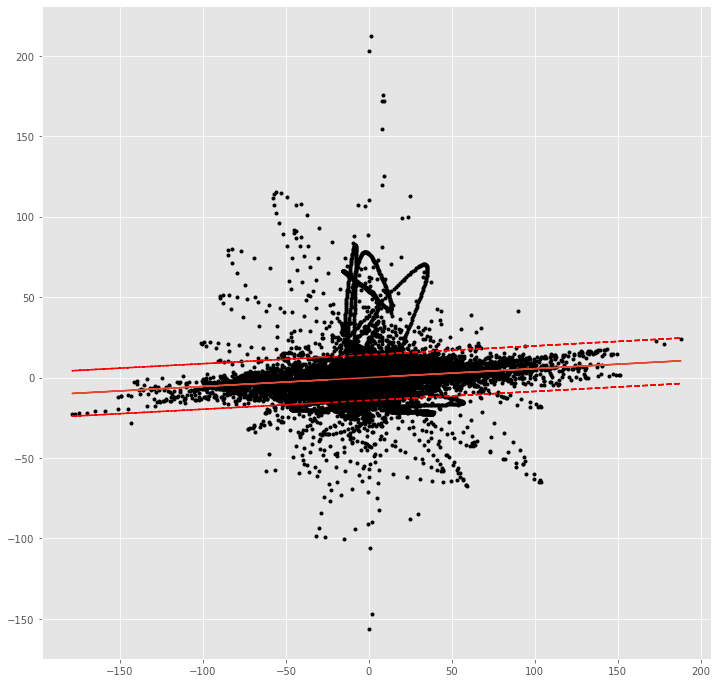

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (12,12))

ax.plot(cLEflat, cMflat, 'k.',
        cLEflat, LS.predict(cLEflat),
        cLEflat, LS.predict(cLEflat) + rmsd, 'r--',
        cLEflat, LS.predict(cLEflat) - rmsd, 'r--')

plt.show()

In [47]:
cMpd = pd.DataFrame(csumM).transpose()
cLEpd = pd.DataFrame(csumLE).transpose()

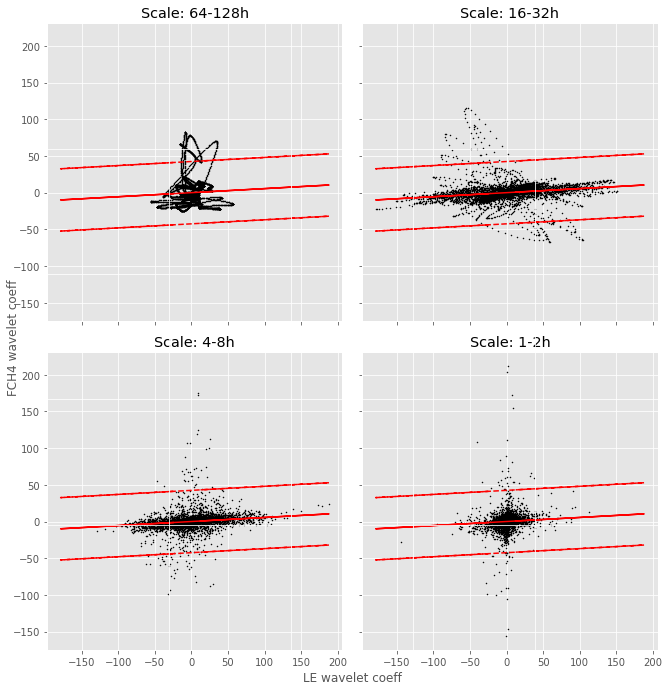

In [27]:
p.scattercoef(cLEpd, cMpd, cLEflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff')

## junk

In [116]:
u = ((cMflat - pred) ** 2).sum()
mse2 = u / len(cMflat)

print('mse: {}'.format(mse))
print('mse2: {}'.format(mse2))

mse: 200.36002224784028
mse2: 200.36002224784028


In [111]:
v = ((cMflat - cMflat.mean()) ** 2).sum()
Rsq = 1-(u/v)
print(Rsq)
print(LS.score(cLEflat, cMflat))

0.012559804682866438
0.012559804682866438
